## Trinity Industries - Train Car Repair Cycle Time Analysis

This notebook dives into a set of train car data. The goal is to better understand what drives repair cycle time and create a model to help predict it in order to improve fleet management efficiency and subsequent businesses that rely on it. It begins with initial thoughts on the data at first glance and goes into exploratory data analysis which includes checking for cleanliness of data and visualization. Following is feature engineering and statistically analysis, finishing up with a quick look at different machine learning algorithms to give an idea what direction the project should be taken in to best predict cycle time.

Review Variables fields:

a. ArrivalDate, DateCompleted – Datetime

b. ShopRecordID – Shopping event Identifier

c. ShopID – Shop location identifier

d. CarModelID – Car model identifier

e. CommodityID – Commodity Type Identifier

f. CycleTime – Time between arrival to completion

g. RepairTypeID – Repair Type Identifier

h. Comp_isHeavy – Heavy work for repair event identifier

Initial thoughts:

- Average cycleTime? Fastest, slowest?

- Most common carmodel/repairtype

- Which shops are most used (based on location, skill, repair type, or other ?)

- Is a certain time of year harder on cars?
    - Increasing repair volume leading to higher cycle time

- Is there any waiting time for the cars after arrival? 
    - ie: is the week the car sits waiting for repair included in cycle time
    - How much do these times vary?
    - Are there priority repairs?

- Figure out which are major factors affecting repair time
    - Are certain car models more laborious to repair
    - Do certain shops work more/less efficiently
    - How does commodity type affect time, if at all
        - Do different commodity types use the same car models?
    - Repair types
        - Which have lowest/highest avg times
    - comp_isHeavy

In [1]:
#import necessary packages

#data manipulating/organizing and plotting
import pandas as pd
import pandas.plotting
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dython import nominal

#set pandas to display all rows within df
pandas.set_option('display.max_rows', None)

#import stats package
from scipy import stats

#machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#deal with any warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

/home/evan/Programming/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#import dataset
df = pd.read_excel(r'/home/evan/Downloads/Copy of datatestset.xlsx')
df.head()

,ArrivalDate,DateCompleted,ShopRecordID,ShopID,CarModelID,CommodityID,CycleTime,RepairTypeID,Comp_isHeavy
0,2018-01-26,2018-03-05,361496,464,1614,63,38.0,18,1
1,2018-03-27,2018-05-11,369711,5738,1762,36,45.0,18,1
2,2018-03-15,2018-08-01,369720,12479,1639,64,139.0,18,0
3,2018-03-15,2018-10-25,370918,12479,1639,64,224.0,18,0
4,2018-01-29,2018-03-07,372819,380,1697,37,37.0,18,1


## EDA and checking for general errors in data

In [32]:
#overview of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3610 entries, 0 to 3609
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ArrivalDate    3610 non-null   datetime64[ns]
 1   DateCompleted  3575 non-null   datetime64[ns]
 2   ShopRecordID   3610 non-null   int64         
 3   ShopID         3610 non-null   int64         
 4   CarModelID     3610 non-null   int64         
 5   CommodityID    3610 non-null   int64         
 6   CycleTime      3575 non-null   float64       
 7   RepairTypeID   3610 non-null   int64         
 8   Comp_isHeavy   3610 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(6)
memory usage: 254.0 KB


3610 total items, 35 items still not completed (3575 completed)

Will probably drop any rows with uncompleted repairs as it wont help predict anything

In [33]:
#statistical overview (mainly relevant for CycleTime)
df.describe()

,ShopRecordID,ShopID,CarModelID,CommodityID,CycleTime,RepairTypeID,Comp_isHeavy
count,3610.000000,3610.000000,3610.000000,3610.000000,3575.000000,3610.0,3610.000000
mean,396417.513296,5811.162881,1716.947091,55.120499,98.002517,18.0,0.708587
std,8551.154689,5354.076195,97.310179,13.947161,78.798666,0.0,0.454476
min,361496.000000,378.000000,843.000000,26.000000,0.000000,18.0,0.000000
25%,388725.250000,380.000000,1639.000000,37.000000,38.000000,18.0,0.000000
50%,395997.500000,5161.000000,1697.000000,63.000000,76.000000,18.0,1.000000
75%,402781.750000,12483.000000,1741.000000,64.000000,135.000000,18.0,1.000000
max,416057.000000,13708.000000,1929.000000,64.000000,611.000000,18.0,1.000000


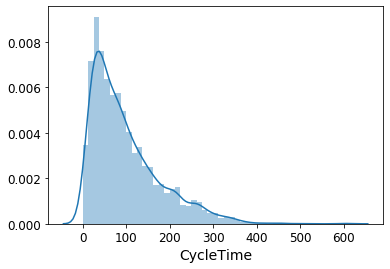

In [34]:
#distribution of repair cycle times
#positive skew
sns.distplot(df['CycleTime'])
plt.show()

Key Findings:
- Average cycle time: 98 days
- Fastest is 0-1 day
- Longest is 611 days
- Strong positive skew to CycleTime distribution
- 70% of repairs are comp heavy
- Only 1 repair type

RepairTypeID is 18 for all rows. If all repair types truly are the same then the huge variance in repair cycle time must be explained by the remaining features (or some possibilities that are not included in the data):
- Different car models require different levels of attention for the same repair (model complexity)
- There is a varying wait time for cars from Arrival Date to Completion Date (idle/wait time)
    - If this is the case it will have a large negative affect on any analysis
- Seasonal changes (also may effect shops differently)
    - Not necessarily weather affecting the shop's ability but the cars; thus increasing shop's volume
- Shops work at difference paces
    - Different staff sizes
    - Different skill levels
- Comp_isHeavy is a major factor
- All of the above

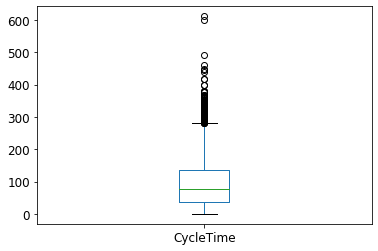

In [35]:
#box and whisker plot of cycle time - note outliers
df.CycleTime.plot(kind='box')
plt.show()

In [7]:
#look at how many repairs took longer than 280 (approx outliers)
df[df['CycleTime'] > 280].count()

ArrivalDate      118
DateCompleted    118
ShopRecordID     118
ShopID           118
CarModelID       118
CommodityID      118
CycleTime        118
RepairTypeID     118
Comp_isHeavy     118
dtype: int64

In [8]:
#distribution of high repair times for each shop
df[df['CycleTime'] > 280].groupby('ShopID')['CycleTime'].count().sort_values()

ShopID
11235     1
8474      1
524       1
543       1
8311      1
12126     1
12483     2
465       2
526       2
5927      2
2365      3
6485      5
830       6
9994      7
5738      7
475       9
516      10
12486    12
380      15
12498    30
Name: CycleTime, dtype: int64

In [9]:
#distribution of high repair times for car models
df[df['CycleTime'] > 280].groupby('CarModelID')['CycleTime'].count().sort_values()

CarModelID
1705     1
1906     1
1897     1
1896     1
1779     1
1769     1
1748     1
1737     1
1734     1
1908     1
1697     1
1670     1
1920     1
1667     1
1669     1
1627     2
1778     2
1744     2
1641     2
1746     2
1611     2
1642     2
1686     2
1687     3
1635     3
1629     3
1614     3
1741     4
1661     4
1620     4
1685     4
1650     5
1639     5
1736     6
1735     7
1895     7
1775    10
1891    19
Name: CycleTime, dtype: int64

118 outliers (above 280 days;) make up ~3% of data. 20 different shops have had a hand in very long repair times; the most common being shop 12498 (30). Car models 1775, and 1891 have the highest count (10, 19 resp.) of slow times but are generally distributed through 38 different models.

In [10]:
#checking for errors in dates (if a completed date comes before arrival)
df[df['DateCompleted'] < df['ArrivalDate']]

,ArrivalDate,DateCompleted,ShopRecordID,ShopID,CarModelID,CommodityID,CycleTime,RepairTypeID,Comp_isHeavy


In [11]:
#Checking for any duplicates in shop record ID's 
#'True' returns means all unique
df["ShopRecordID"].is_unique

True

In [12]:
#take a look at shops used and frequency used (count # of shop records)
shops = df.groupby('ShopID')['ShopRecordID'].nunique()
shops.sort_values()

ShopID
8474       1
13334      1
6819       1
9926       1
12848      1
6544       2
1016       2
12484      2
13332      2
6834       3
12949      3
707        3
11095      4
8666       5
476        8
524       14
13573     16
11868     17
12483     27
475       30
8311      30
12347     31
516       34
6074      37
526       37
465       45
13708     46
5927      54
543       56
6485      56
12479     57
11235     57
2365      57
378       57
10262     59
10092     66
592       67
5161      74
9994      93
12126    105
12486    119
2406     128
12493    133
830      138
464      171
5738     206
12498    568
380      886
Name: ShopRecordID, dtype: int64

In [13]:
#number of shops
shops.count()

48

There are 48 different shops used within this data set. One shop (380) has made almost a quarter of all repairs. 

In [14]:
#unique commodity ID's and their counts
df.groupby('CommodityID')['ShopRecordID'].nunique().sort_values()

CommodityID
52       3
62       3
34       6
38      10
60      49
27     129
36     134
26     233
37     486
63     876
64    1681
Name: ShopRecordID, dtype: int64

11 different commodities; almost half of repairs are on cars with the same commodity.

In [15]:
#count of heavy/not heavy
df.groupby('Comp_isHeavy')['ShopRecordID'].nunique().sort_values()

Comp_isHeavy
0    1052
1    2558
Name: ShopRecordID, dtype: int64

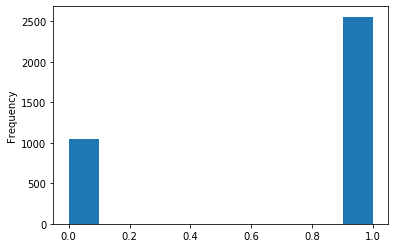

In [16]:
#histo of heavy vs not
df.Comp_isHeavy.plot(kind='hist')
plt.show()

Almost 3/4 of the repairs are heavy work.

In [17]:
#grouping by model ID's to see which are most/not commonly repaired
carmodel = df.groupby('CarModelID')['ShopRecordID'].nunique()
carmodel.sort_values()

CarModelID
843       1
1663      1
1669      1
1673      1
1679      1
1715      1
1928      1
1657      1
1725      1
1745      1
1748      1
1751      1
1770      1
1771      1
1774      1
1731      1
1643      1
1929      1
1612      1
1616      1
1622      1
1892      2
1676      2
1726      2
1618      2
1916      2
1749      2
1698      2
1920      2
1769      2
1598      2
1772      2
1773      2
1761      2
1688      2
1630      3
1470      3
1778      3
1905      3
1755      4
1919      4
1597      4
1734      4
1763      5
1724      5
1922      5
1607      6
1747      6
1737      6
1615      6
1641      6
1762      6
1742      6
1896      6
1779      6
1706      7
1739      7
1766      8
1743      8
1760      8
1601      8
1904      8
1672      9
1705      9
1661     10
1613     10
1746     11
1677     12
1602     13
1670     14
1686     17
1619     19
1632     20
1699     21
1906     22
1744     22
1629     22
1909     22
1757     22
1923     23
1908     23
1627     24
1634 

107 different types of car models. Some models are repaired more often than others - this may be due to the actual model requiring more constant maintainence or there are more of those models in deployment and/or used more frequently and so needing more attention on a regular basis.

More data on this would be useful to have a better understanding.

Plot cycle times based on time of year using arrival date.

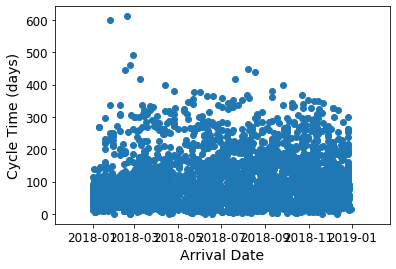

In [41]:
#plot cycle times throughout year based on arrival dates

#exclude completion date
dates = df.drop(['DateCompleted'], axis=1)

#scatter plot - cycle time for cars arrival dates
plt.scatter(dates.ArrivalDate, df.CycleTime)
plt.ylabel('Cycle Time (days)')
plt.xlabel('Arrival Date')
plt.show()

In [42]:
#looking for monthly/seasonal trends
#extract months so data can be grouped
dates['Date'] = dates['ArrivalDate'].astype('datetime64')
dates['Month'] = dates['ArrivalDate'].dt.strftime('%Y-%m')
dates = dates.groupby('Month').size().to_frame(name='Count')
dates

,Count
Month,
2018-01,321
2018-02,235
2018-03,287
2018-04,243
2018-05,272
2018-06,351
2018-07,323
2018-08,295
2018-09,269


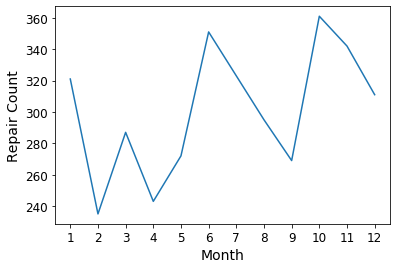

In [40]:
#plot repair count for each month in 2018 for arrivals
positions = (range(12))
labels = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
plt.xticks(positions, labels)

plt.ylabel('Repair Count')
plt.xlabel('Month')
plt.plot(dates)
plt.show()

Overall there is not a huge change in arrivals for repairs throughout the year - cars appear to be largely unimpacted by time/seasons.

Quick summary of key findings:

- Data appears to be clean
- Only one repair type is being handled
- 118 outliers in data over 280 days of repair time
- 48 shops
    - Repairs are not evenly distributed
- 107 car models
    - Are these all unique cars or could different repairs on the same model # be diff cars?
- 11 unique commodity types
    - Do these affect cycle times?
- ~3/4 of repairs are on comp heavy
- No obvious seasonal trend
    - May be worth revisiting looking at other factors and with more data


## Feature Engineering

Here we'll try to optimize the data for analysis!

Having found a small percentage of null values in the data (uncompleted repairs) rather than guessing the values they'll simply be taken out. If it was more of a significant portion of data it may make more sense to try to fill in rather than exclude.

Since we're more interested in cycle time rather than actual dates the arrival and completed dates will be taken out for modeling. The dates may be useful for a time series analysis but more data would be ideal.

Outliers can often have have negative impacts on algorithms so for this initial dive they'll be removed but it may be worth revisiting later as it is still real data.

Generally with categorical features the values would need to be converted using one-hot encoding or another technique in order for the machine learning model to better understand and use it within the algorithm. However, since these variables are all already numerical it should work fine.



In [22]:
#remove any rows with null values (35 data points)

#Note: often times it makes sense to try to fill in these values
#with averages or guessing using the closest values
#however with such a small percentage of NULL it makes little difference
dff = df.dropna()

#remove outliers (118 rows)
dff = dff[dff.CycleTime < 280]

#remove repair type column (all the same)
#remove arrival and completed dates (more interested in cycle time)
#remove ShopRecordID as this shouldn't have any impact on cycle time and would be excess noise

#Note: it may be interesting to see if repair times have improved over longer
#periods of time but all this data is within 2018/19 so likely no major changes

dff = dff.drop(['ArrivalDate', 'DateCompleted', 'RepairTypeID', 'ShopRecordID'], axis = 1) 
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3450 entries, 0 to 3608
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ShopID        3450 non-null   int64  
 1   CarModelID    3450 non-null   int64  
 2   CommodityID   3450 non-null   int64  
 3   CycleTime     3450 non-null   float64
 4   Comp_isHeavy  3450 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 161.7 KB


## Statistical Analysis

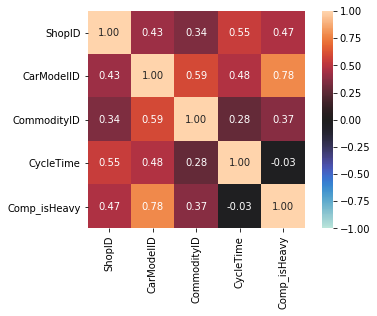

{'corr':                 ShopID  CarModelID  CommodityID  CycleTime  Comp_isHeavy
 ShopID        1.000000    0.429255     0.344962   0.550041      0.470150
 CarModelID    0.429255    1.000000     0.593797   0.480427      0.784712
 CommodityID   0.344962    0.593797     1.000000   0.276248      0.369500
 CycleTime     0.550041    0.480427     0.276248   1.000000     -0.033955
 Comp_isHeavy  0.470150    0.784712     0.369500  -0.033955      1.000000,
 'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb255ce6c10>}

In [23]:
#use a nominal associations heatmap for categorical features
#interested in correlations with CycleTime

nominal.associations(dff, nominal_columns=['CarModelID', 'CommodityID', 'ShopID'])

With a quick correlation heatmap we can see some correlations between the variables. Comp_isHeavy has a slight negative relationship with CycleTime while ShopID and CommodityID have positive relationships.

I'm interested in the average cycle times for the cars so let's calculate that.

In [24]:
#average repair cycle time for each car model
car_avgs = dff.groupby('CarModelID')['CycleTime'].mean()
car_avgs.sort_values()

CarModelID
1725     19.000000
1739     22.571429
1898     31.860656
1598     33.500000
1622     34.000000
1715     38.000000
1698     38.500000
1724     41.600000
1751     43.000000
1779     43.400000
1762     46.000000
1760     49.625000
1657     51.000000
1899     51.125000
1597     52.250000
1623     55.285714
1719     55.943787
1726     56.500000
1909     58.636364
1670     59.923077
1778     60.000000
1919     60.000000
1630     61.000000
1627     62.000000
1601     62.000000
1755     62.250000
1635     62.375000
1763     64.000000
1688     65.500000
1620     67.882353
1602     73.461538
1922     75.600000
1929     76.000000
1699     76.952381
1634     77.000000
1614     79.979452
1618     80.500000
1613     81.100000
1619     82.263158
843      85.000000
1612     85.000000
1697     85.056911
1897     85.158537
1611     90.023810
1736     90.662252
1706     90.857143
1685     91.746575
1632     92.388889
1615     92.600000
1749     93.500000
1896     94.500000
1643     95.000000
1

Next let's look at the effect of the car model has on cycle time by using a Krustal Wallis test - using the most often repaired car models.

Null hypothesis: Different car models have no effect on repair cycle time.

Alternative: Car models have a positive or negative effect on cycle time.

In [25]:
#create vars for cycletime values for 3 most repaired car models
a = dff.loc[dff['CarModelID'] == 1697, 'CycleTime']
b = dff.loc[dff['CarModelID'] == 1719, 'CycleTime']
c = dff.loc[dff['CarModelID'] == 1639, 'CycleTime']

In [26]:
#run kruskal wallis test on models
stats.kruskal(a, b, c)

KruskalResult(statistic=94.98854216118242, pvalue=2.363198202760553e-21)

The test statistic is quite high and the p-value is very small - enough to reject the null hypothesis and conclude that different car models do have a significant impact on repair cycle time.

## Machine Learning

Here machine learning algorithms will be used in an attempt to predict repair cycle times based off of other available variables.

In [44]:
#create dataframe for use with machine learning models
df_ml = dff.copy()

#create array to use as predictor columns in regression models
X = df_ml.filter(['ShopID', 'CarModelID', 'CommodityID', 'Comp_isHeavy'], axis =1).values

#values to be predicted
y = df_ml.loc(axis=1)['CycleTime'].values

In [45]:
#split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5)

#data scaling to standardize values to normal distributions
#scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
#X_train = scaling.transform(X_train)
#X_test = scaling.transform(X_test)

In [47]:
#cycle through different model types to get best fit models

#create list of models with names
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVC', LinearSVC()))

# evaluate each model
results = []
names = []
scoring = 'accuracy'
msgs = []
@ignore_warnings(category=ConvergenceWarning)

#loops through all models in a list to caclulate accuracy using cross validation scoring/optimizing 
def scores_list():
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=5, shuffle=True)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        msgs.append(msg)
scores_list()

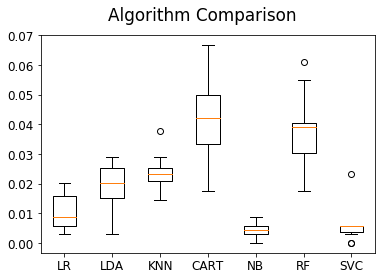

In [48]:
# plot model accuracies with a box plot
# boxplot algorithm comparison
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Quick comparison of algorithms shows that random forest (RF) and the decision tree classifier (CART) may be the best options to move forward with. While working with regression problems accuracy is not the main metric to go by it can be an okay starting point. Root mean square error (RMSE) may be the best way to check for most regression problems. While accuracy just looks at all correct predictions divided by all of them the RMSE takes into account the errors of each prediction - calculating the average magnitude of the error and gives higher weight the larger the error is. If larger errors are less of an issue than MAE can be used which does a similar calculation without squaring the errors (thus lower weights even for larger errors).

In this case I would pursue the decision tree classifier and random forest algorithms and use the scikitlearn gridcv package to find the optimal combination of hyperparameters to achieve the best model for predicting cycle times. Potentially changing around some feature engineering in order to achieve better results (include outliers, bootstrap data, etc).

## Conclusion

Using this relatively small set of data we are able to predict cycle time with a ~60% level of accuracy. 
The biggest negative impact on cycle time appears to be comp_isHeavy, and the biggest positive impact is the ShopID. 

This model can be used to help inform the company/clients of expected cycle time based on the available information of cars. Using this they will be able to make better decisions for their train fleets to optimize management.


### Next Steps

While this has helped better understand and give some insight as far as predictability - it could be greatly beneficial to run similar analysis using a larger and more comprehensive set of data (more repair types, etc).

Further in the future it may be worth it to design, program, and implement a system that can help make decisions for when and how cars should be repaired - focusing on the best time for an area, which shop may be best to stop at, if its worth it to continue to another location etc. This system would also have a huge benefit if it had access to real-time updates on shop wait-times (current volume), average repair costs, and weather.